In [8]:
%load_ext lab_black

from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.io import wavfile
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import serial
import sys

BASE_PATH = os.path.join("/tf/notebooks/CEIA/ia-embebida/tp-final")
sys.path.insert(0, BASE_PATH)

from NoiseGate import NoiseGate

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


Se carga el archivo de audio

In [9]:
base_path = "/tf/notebooks/CEIA/ia-embebida/noise-gate"
assets_path = os.path.join(base_path, "assets")
audios_path = os.path.join(assets_path, "audios")

samplerate, data = wavfile.read(os.path.join(audios_path, "recording_01.wav"))

data_len = len(data)
duration = data_len / samplerate
print(f"Cantidad de muestras: {data_len}")
print(f"Frecuencia de muestreo: {samplerate} Hz")
print(f"Duracion: {duration:.1f} segundos")
print(f"Valor maximo: {max(data)}")
print(f"Valor minimo: {min(data)}")
print(f"Tipo de dato: {type(data[0])}")

Cantidad de muestras: 956007
Frecuencia de muestreo: 22050 Hz
Duracion: 43.4 segundos
Valor maximo: 32767
Valor minimo: -32768
Tipo de dato: <class 'numpy.int16'>


/tmp/ipykernel_99/1952448994.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(os.path.join(audios_path, "recording_01.wav"))


Diseñamos un filtro pasa bajo con una banda de paso de hasta 2000Hz y lo aplicamos a nuestra señal

In [10]:
filter_order, wn = signal.buttord(
    wp=2000, ws=3000, gpass=3, gstop=40, analog=False, fs=samplerate
)
b, a = signal.butter(filter_order, wn, "lowpass", analog=False, fs=samplerate)

filtered_data = signal.lfilter(b, a, data)

Hacemos la decimación y reducimos la frecuencia de muestreo 10 veces, es decir a 2.2KHz

In [11]:
dec_data = filtered_data[::10]

dec_samplerate = samplerate / 10
dec_data_len = len(dec_data)

Elevamos los valores al cuadrado

In [12]:
squared_data = dec_data**2

Aplicamos la compuerta de ruido

In [13]:
OPEN_LIMIT = 3500
CLOSE_LIMIT = 300
HOLD = 0.3

noise_gate = NoiseGate(OPEN_LIMIT, CLOSE_LIMIT, HOLD, dec_samplerate)
results_noise_gate = []
tmp = []

for value in squared_data:
    result = noise_gate.transform(value)

    if result != None:
        tmp.append(result)
    elif len(tmp) != 0:
        results_noise_gate.append(tmp)
        tmp = []

print(f"Cantidad de eventos: {len(results_noise_gate)}")

Cantidad de eventos: 51


Implementamos el filtro de media móvil en el ESP y le pasamos los valores de la salida de la compuerta de ruido. El micro devolverá los valores filtrados.

In [14]:
PORT = "/dev/ttyUSB0"
BAUD_RATE = 115200

serial_port = serial.Serial(PORT, BAUD_RATE, timeout=0.25)
serial_port.flushInput()

results_esp = []
for event in results_noise_gate:
    results_event = []
    for sample in event:
        data_uint = int(sample)
        serial_port.write(data_uint.to_bytes(4, "little"))
        bytes = serial_port.read(4)
        result = int.from_bytes(bytes, "little")
        results_event.append(result)
    results_esp.append(results_event)

serial_port.close()

In [18]:
results_esp[1]

[1400285,
 2630059,
 5005071,
 8418568,
 9967182,
 10001121,
 13962893,
 24877307,
 38412401,
 49044327,
 54504871,
 55663579,
 55855605,
 59510170,
 67779941,
 78082489,
 86969729,
 92796873,
 95270779,
 95566454,
 94729837,
 96426748,
 99712144,
 102775456,
 106307909,
 109133604,
 106188265,
 95400748,
 81908345,
 71686006,
 66601880,
 67143995,
 80332891,
 87855662,
 79601648,
 84198098,
 96188184,
 101615191,
 102492806,
 102206834,
 109708332,
 135383353,
 162803482,
 178437647,
 184286929,
 185780978,
 185468639,
 186097851,
 196968348,
 224355931,
 253998311,
 278357020,
 281179415,
 277370881,
 279304055,
 264403604,
 245641128,
 242477654,
 252311460,
 263892113,
 261687931,
 234759209,
 201713613,
 179901967,
 168981293,
 165825514,
 170907164,
 176635950,
 167870118,
 140459603,
 110828461,
 88997125,
 83879292,
 88504979,
 93939624,
 96297977,
 94274242,
 86515957,
 75204491,
 69346818,
 71940022,
 78712278,
 81567252,
 81281999,
 81265082,
 80065932,
 74684638,
 68288028,

In [30]:
event_duration

0.39319727891156464

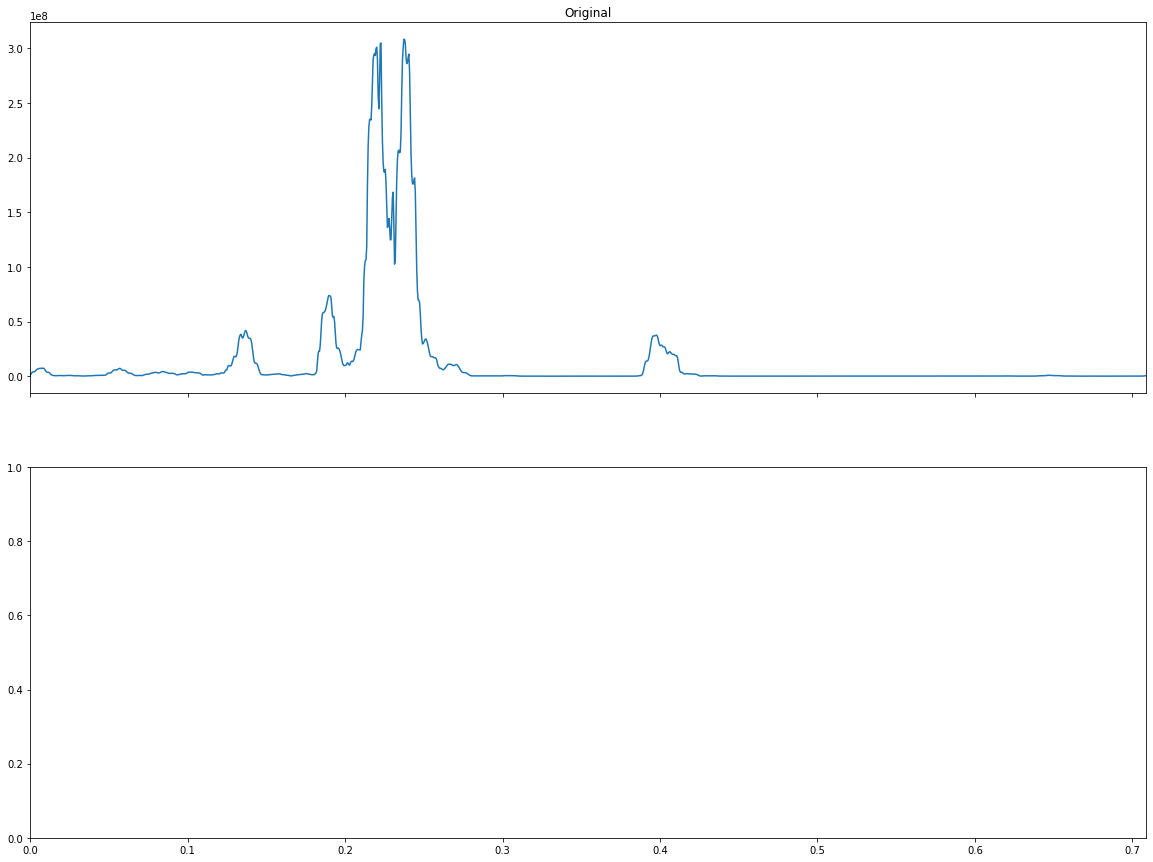

In [39]:
sample_event = results_esp[5]
event_duration = len(sample_event) / dec_samplerate
timeline = np.linspace(0, event_duration, num=len(sample_event))

f, axes = plt.subplots(2, sharex=True, figsize=(20, 15))

axes[0].plot(timeline, sample_event)
axes[0].set_xlim([0, event_duration])
axes[0].set_title("Original")

f.show()